Generate data set with same covariance matrix as P(k) but with actually Gaussian likelihoods

In [1]:
import numpy as np 
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline 

function to read in P(k) from Nseries mock catalogs

In [2]:
def readPk(i, rebin=20): 
    ''' Read P(k) in dat/ directory
    '''
    # read in Pk from dat
    file = ''.join(['dat/', 'power_CutskyN', str(i), '.dat.grid360.P020000.box3600'])
    k, Pk, counts = np.loadtxt(file, unpack=True, usecols=[0,1,-1])
    
    # re-bin 
    tot_counts, avg_k, avg_Pk = [], [], []
    
    i_threshold = (np.abs(k[::rebin] - 0.05)).argmin()
    for ii in range(i_threshold*rebin)[::2]: 
        indices = range(len(k))[ii:ii+2]

        # all mode counts 
        allcounts = np.sum(counts[indices])
        tot_counts.append(allcounts)
        avg_k.append(np.sum(k[indices] * counts[indices])/allcounts)
        avg_Pk.append(np.sum(Pk[indices] * counts[indices])/allcounts)
        
    for istart in range(len(k))[::rebin]: 
        if istart < i_threshold*rebin: 
            continue 
        indices = range(len(k))[istart:istart+rebin]

        # all mode counts 
        allcounts = np.sum(counts[indices])
        tot_counts.append(allcounts)
        avg_k.append(np.sum(k[indices] * counts[indices])/allcounts)
        avg_Pk.append(np.sum(Pk[indices] * counts[indices])/allcounts)

    return [np.array(avg_k), np.array(avg_Pk)]

In [3]:
def scale(X, axis=0, info=True):
    ''' re-implementing preprocessing.scale
    '''
    X = np.array(X)
    mean_ = np.mean(X, axis)
    scale_ = np.std(X, axis)

    Xr = np.rollaxis(X, axis)

    Xr -= mean_
    scale_ = preprocessing.data._handle_zeros_in_scale(scale_, copy=False)
    Xr /= scale_
    if not info: 
        return X 
    else: 
        return X, mean_, scale_

Read in all the Nseries mock catalog P(k)s

In [115]:
all_pk = []
for i in range(84): 
    k, pk = readPk(i+1, rebin=20)
    all_pk.append(pk)
all_pk = np.array(all_pk)

In [116]:
# now pre-process it
pkt, mu_pk, scale_pk = scale(all_pk)
pks = pkt.T
cov = np.cov(pks)

<matplotlib.colorbar.Colorbar instance at 0x1119e3f80>

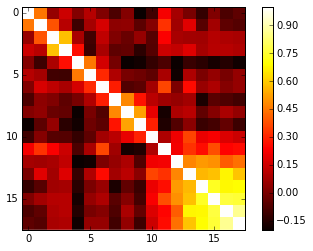

In [117]:
plt.imshow(cov, interpolation='None', cmap='hot')
plt.clim(-0.2, 1.)
plt.colorbar()

generate random dataset from Gaussian that will have the same covariance matrix

In [118]:
random = np.random.normal(size=pks.shape)
L = np.linalg.cholesky(cov)
pk_gauss = np.dot(L, random)

<matplotlib.colorbar.Colorbar instance at 0x111b89758>

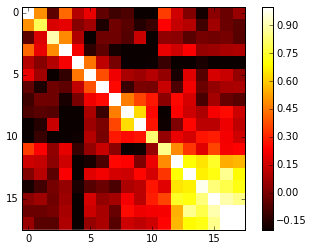

In [119]:
plt.imshow(np.cov(pk_gauss), interpolation='None', cmap='hot')
plt.clim(-0.2, 1.)
plt.colorbar()

Lets compare P(k) from Nseries with P(k) from Gaussian

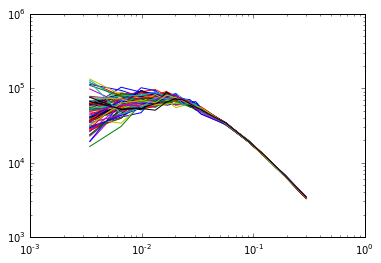

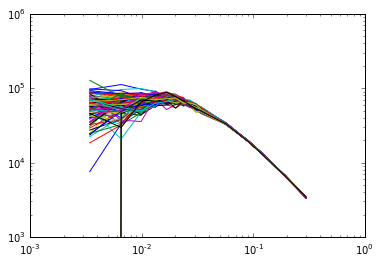

In [100]:
for i in range(84):    
    plt.plot(k, all_pk[i])
plt.xscale('log')
plt.yscale('log')
plt.figure()
for i in range(84):    
    plt.plot(k, pk_gauss[:,i] * scale_pk + mu_pk)
plt.xscale('log')
plt.yscale('log')

Now lets whiten the scaled P(k)s 

In [101]:
inv_cov = np.linalg.pinv(cov)
L = np.linalg.cholesky(inv_cov) # whitening matrix
W = L.T

<matplotlib.colorbar.Colorbar instance at 0x110eedc20>

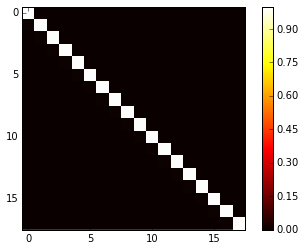

In [102]:
pk_w = np.dot(W, pks)
plt.imshow(np.cov(pk_w), interpolation='none', cmap='hot')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x1110838c0>

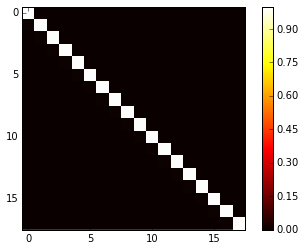

In [103]:
inv_cov_gauss = np.linalg.pinv(np.cov(pk_gauss))
L_gauss = np.linalg.cholesky(inv_cov_gauss) # whitening matrix
W_gauss = L_gauss.T

pk_w_gauss = np.dot(W_gauss, pk_gauss)
plt.imshow(np.cov(pk_w_gauss), interpolation='none', cmap='hot')
plt.colorbar()

In [104]:
def gauss(x, mu=0., sigma=2.): 
     return 1./(np.sqrt(2.*np.pi)*sigma)*np.exp((-(x-mu)**2)/(2*sigma))
    
def s_plus(dataset, i, e, f): 
    return dataset[i, e] + dataset[i, f]

def S_plus(dataset):
    Splus = np.zeros((dataset.shape[0], dataset.shape[0]))
    for i in range(Splus.shape[0]): 
        for j in range(Splus.shape[1]):
            psplus, bin_edge = np.histogram([s_plus(dataset.T, i_s, i, j) for i_s in range(dataset.shape[1])])
            bin_mid = 0.5*(bin_edge[1:] + bin_edge[:-1])
            Splus[i,j] = np.sum((psplus - gauss(bin_mid, mu=0., sigma=2.))**2)/np.float(len(bin_mid))
            
    return Splus

<matplotlib.colorbar.Colorbar instance at 0x1112092d8>

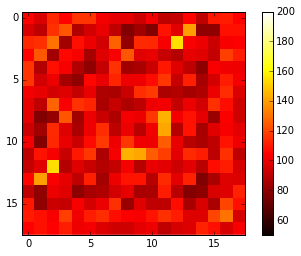

In [105]:
Splus_pk_w = S_plus(pk_w)
plt.imshow(Splus_pk_w, interpolation='none', cmap='hot')
plt.clim(50., 200)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x11138aef0>

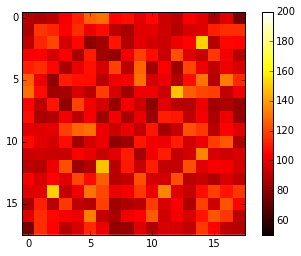

In [106]:
Splus_pk_w_gauss = S_plus(pk_w_gauss)
plt.imshow(Splus_pk_w_gauss, interpolation='none', cmap='hot')
plt.clim(50., 200)
plt.colorbar()